## Setup environment

In [1]:
# from swincell.utils import plot_utils
# from plot_utils import *
import sys
sys.path.append('/home/xzhang/Projects/swincell_backup')
from swincell import *
# from swincell.utils import plot_utils

ModuleNotFoundError: No module named 'swincell'

In [2]:
pwd

'/home/xzhang/Projects/swincell_backup/swincell/notebooks_plot_results'

In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.10.dev2225
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6a2067a26b69aee6bcb4cf2b7adcda2c6e9adaed
MONAI __file__: /home/xzhang/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

# Setup dataset directory

In [6]:
from natsort import natsorted
import numpy as np
import pandas as pd
import glob
import tifffile
from matplotlib import pyplot as plt
from stardist_matching import matching
import scipy.ndimage as ndimage
from cv2_utils import get_random_cmap
root_folder = '/data/download_data/colon_dataset/colon_30/'

# seg_files = natsorted(glob.glob(root_folder + '/prediction*/*.tiff'))  # v1
# seg_files = natsorted(glob.glob(root_folder + '/prediction_results_3dswinunetr*/cellpose_*.tiff')) # v2, good results contrast 80-255

# seg_files = natsorted(glob.glob(root_folder + '/*contrast_1_255*/cellpose_*.tiff')) # v3 adjusted contrast, bad results
seg_files = natsorted(glob.glob('/data/download_data/colon_dataset/colon_30/prediction_test_volume_v2_1_255_swinunetr_monai_minsize2500/cellpose_*.tiff'))  #v4

# print(len(image_files), len(seg_files), len(gt_files))

In [7]:
# additional matching, added results of 2d Cellpose for comparasion, batch matcing function need to be imported

fold = 1

gt_files = natsorted(glob.glob(root_folder + '/labels/*.tif'))
gt_files_2d =[f for i,f in enumerate(gt_files) if i%5 == fold]
seg_files_2d = natsorted(glob.glob(root_folder + '/results_2d_cellpose_algo2_after_training/*0.25_dia_25.tif*'))

print(len(gt_files_2d),len(seg_files_2d))


df_match_2d = batch_matching(gt_files_2d, seg_files_2d,to_instance=True)
# df_match_2d.to_csv('output_swinunetr_30_colon_dataset_2d_cellpose.csv')

6 6


NameError: name 'batch_matching' is not defined

In [8]:
# 
def batch_matching(gt_files, seg_files, thresh_list=[0.5,0.625,0.75,0.875,1], downsample_factor=1,to_instance=False):
    if len(gt_files) != len(seg_files):
        raise ValueError('number of ground truth and prediction images do not match')
    output_df = pd.DataFrame()
    for i in range(len(gt_files)):
        for idxt,threshold in enumerate(thresh_list):
            gt_img = tifffile.imread(gt_files[i])
            if to_instance:
                from skimage import measure
                gt_img = measure.label(gt_img,background=0)
                

            # results 3d
            seg_img = tifffile.imread(seg_files[i])
            match_3d = matching(gt_img,seg_img,  thresh=threshold)
            
            df_temp = pd.DataFrame([match_3d])
            df_temp['img_id'] = str(gt_files[i].split('/')[-1])
            output_df = pd.concat([output_df,df_temp])
    return output_df
    # evaluate segmentation results and save results in a dataframe

df_match = batch_matching(gt_files, seg_files,to_instance=True)
df_match.head()

KeyboardInterrupt: 

In [5]:
import pandas as pd
# df_match.to_csv('output_swinunetr_30_colon_dataset_v4.csv')

df_match = pd.read_csv('output_swinunetr_30_colon_dataset_v4.csv')
df_match_06 = df_match[df_match['img_id']=='image-labels_0006.tif']
df_match_06.head(10)

,Unnamed: 0,criterion,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,img_id
30,0,iou,0.500,12,427,32,0.972665,0.930283,0.906582,0.951002,459,439,0.857154,0.921390,0.876244,image-labels_0006.tif
31,0,iou,0.625,15,424,35,0.965831,0.923747,0.894515,0.944321,459,439,0.853538,0.923995,0.872547,image-labels_0006.tif
32,0,iou,0.750,28,411,48,0.936219,0.895425,0.843943,0.915367,459,439,0.833492,0.930834,0.852055,image-labels_0006.tif
33,0,iou,0.875,59,380,79,0.865604,0.827887,0.733591,0.846325,459,439,0.776942,0.938464,0.794246,image-labels_0006.tif
34,0,iou,1.000,439,0,459,0.000000,0.000000,0.000000,0.000000,459,439,0.000000,0.000000,0.000000,image-labels_0006.tif


In [6]:
N_thresholds =5
df_match_05 = df_match[df_match['thresh']==0.5]
# mAP_3d_list =df_match_05['precision'].values.reshape(len(gt_files),N_thresholds)
# f1_3d_list =df_match_05['f1'].values.reshape(len(gt_files),N_thresholds)
# fp_3d_list=df_match_05['fp'].values.reshape(len(gt_files),N_thresholds)
# tp_3d_list =df_match_05['tp'].values.reshape(len(gt_files),N_thresholds)
# fn_3d_list=df_match_05['fn'].values.reshape(len(gt_files),N_thresholds)

mAP_3d_list =df_match_05['precision'].values
f1_3d_list =df_match_05['f1'].values
recall_3d_list=df_match_05['recall'].values
accuracy_3d_list =df_match_05['accuracy'].values
fn_3d_list=df_match_05['fn'].values

print(mAP_3d_list)


[0.97330097 0.97634409 0.98221344 0.98214286 0.99784483 0.97565543
 0.97266515 0.97278912 0.97512438 0.99506173 0.84756098 0.97350993
 0.97706422 0.98372093 0.95544554 0.94629156 0.98594848 0.98356808
 0.98308668 0.97598253 0.92207792 0.98529412 0.83646617 0.94142259
 0.9490835  0.93644068 0.98920086 0.95545657 0.96473552 0.98484848]


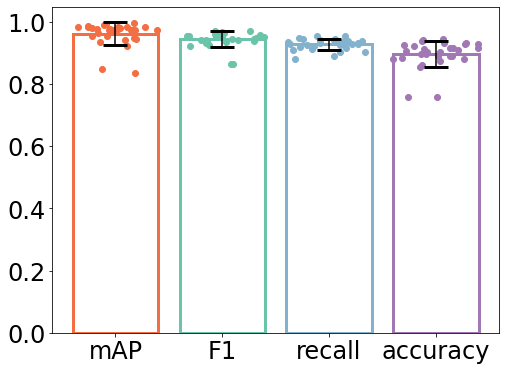

In [7]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)

w = 0.8    # bar width
x = [1, 2,3,4] # x-coordinates of your bars
# colors = [(0, 0, 1, 1), (1, 0, 0, 1), (0, 1, 0, 1), (0, 1, 1, 1)]    # corresponding colors
# colors =[['#c0e1dd', '#dac3d8'],['#82b2cd', '#a177b4'] ]

colors = [(0.95294118, 0.43137255, 0.25882353),(0.41176471, 0.76862745, 0.6627451 ),(0.5098039215686274, 0.6980392156862745, 0.803921568627451),(0.6313725490196078, 0.4666666666666667, 0.7058823529411765)]

# colors = [tuple([243,110,66]/255),tuple([105,196,169]/255),(0.5098039215686274, 0.6980392156862745, 0.803921568627451),(0.6313725490196078, 0.4666666666666667, 0.7058823529411765)]
# cap_colors = ['blue', 'red', 'green', 'cyan']
y=[mAP_3d_list,f1_3d_list,recall_3d_list,accuracy_3d_list]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["mAP", "F1","recall", "accuracy"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       linewidth = 3,

       error_kw={'capthick': 3}, 
       )


# ax.set_axis_off()
for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])

# set font size
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.grid(False)
# ax.set_xticklabels(["mAP", "f1","recall", "accuracy"], fontsize=20)  # Adjust the fontsize as needed
plt.show()


ValueError: operands could not be broadcast together with shapes (2,) (30,) 

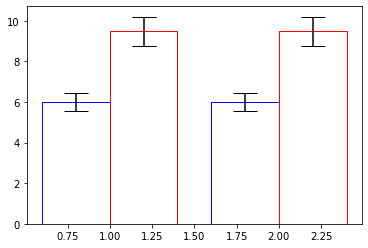

In [24]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)

w = 0.4  # bar width
x = np.array([1, 2])  # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]  # corresponding colors for the groups
group_names = ["control", "test"]
group_offsets = np.array([-w / 2, w / 2])  # offsets for the two groups

# Sample data for two groups
y_group1 = np.random.random(30) * 2 + 5
y_group2 = np.random.random(10) * 3 + 8

fig, ax = plt.subplots()

# Plot bars for Group 1
ax.bar(x + group_offsets[0],
       height=np.mean(y_group1),
       yerr=np.std(y_group1),
       capsize=12,
       width=w,
       color=(0, 0, 0, 0),
       edgecolor=colors[0],
       label=group_names[0])

# Plot bars for Group 2
ax.bar(x + group_offsets[1],
       height=np.mean(y_group2),
       yerr=np.std(y_group2),
       capsize=12,
       width=w,
       color=(0, 0, 0, 0),
       edgecolor=colors[1],
       label=group_names[1])

# Scatter points for Group 1
b = x + group_offsets[0]+ np.random.random(y_group1.size)
print(b)
ax.scatter(x + group_offsets[0] + np.random.random(y_group1.size) * w - w / 2, y_group1, color=colors[0])

# Scatter points for Group 2
ax.scatter(x + group_offsets[1] + np.random.random(y_group2.size) * w - w / 2, y_group2, color=colors[1])

# Set x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(group_names)

# Set labels and title
ax.set_ylabel("Values")
ax.set_title("Bar Plot with Scatter Points for Two Groups")

# Add legend
ax.legend()

plt.show()


## show example images 

In [16]:
# load files, define file location
# 3D model was tested all the 30 data images, 2D model was tested on only the test data set
fold = 1
root_folder = '/data/download_data/colon_dataset/colon_30/'

image_files = natsorted(glob.glob(root_folder + '/images/*.tif'))
seg_files_3d = natsorted(glob.glob('/data/download_data/colon_dataset/colon_30/prediction_test_volume_v2_1_255_swinunetr_monai_minsize2500/cellpose_*.tiff'))  #v4
seg_files_2d = natsorted(glob.glob(root_folder + '/results_2d_cellpose_algo2_after_training/*0.25_dia_25.tif*'))
gt_files = natsorted(glob.glob(root_folder + '/labels/*.tif'))

image_files =[f for i,f in enumerate(image_files) if i%5 == fold]
gt_files =[f for i,f in enumerate(gt_files) if i%5 == fold]
seg_files_3d =[f for i,f in enumerate(seg_files_3d) if i%5 == fold]


print(len(image_files),len(seg_files_3d),len(seg_files_2d),len(gt_files))

# print(image_files[1])

6 6 6 6


gt min max 459 0 seg min max 439 0
(129, 1030, 1300)
432 0


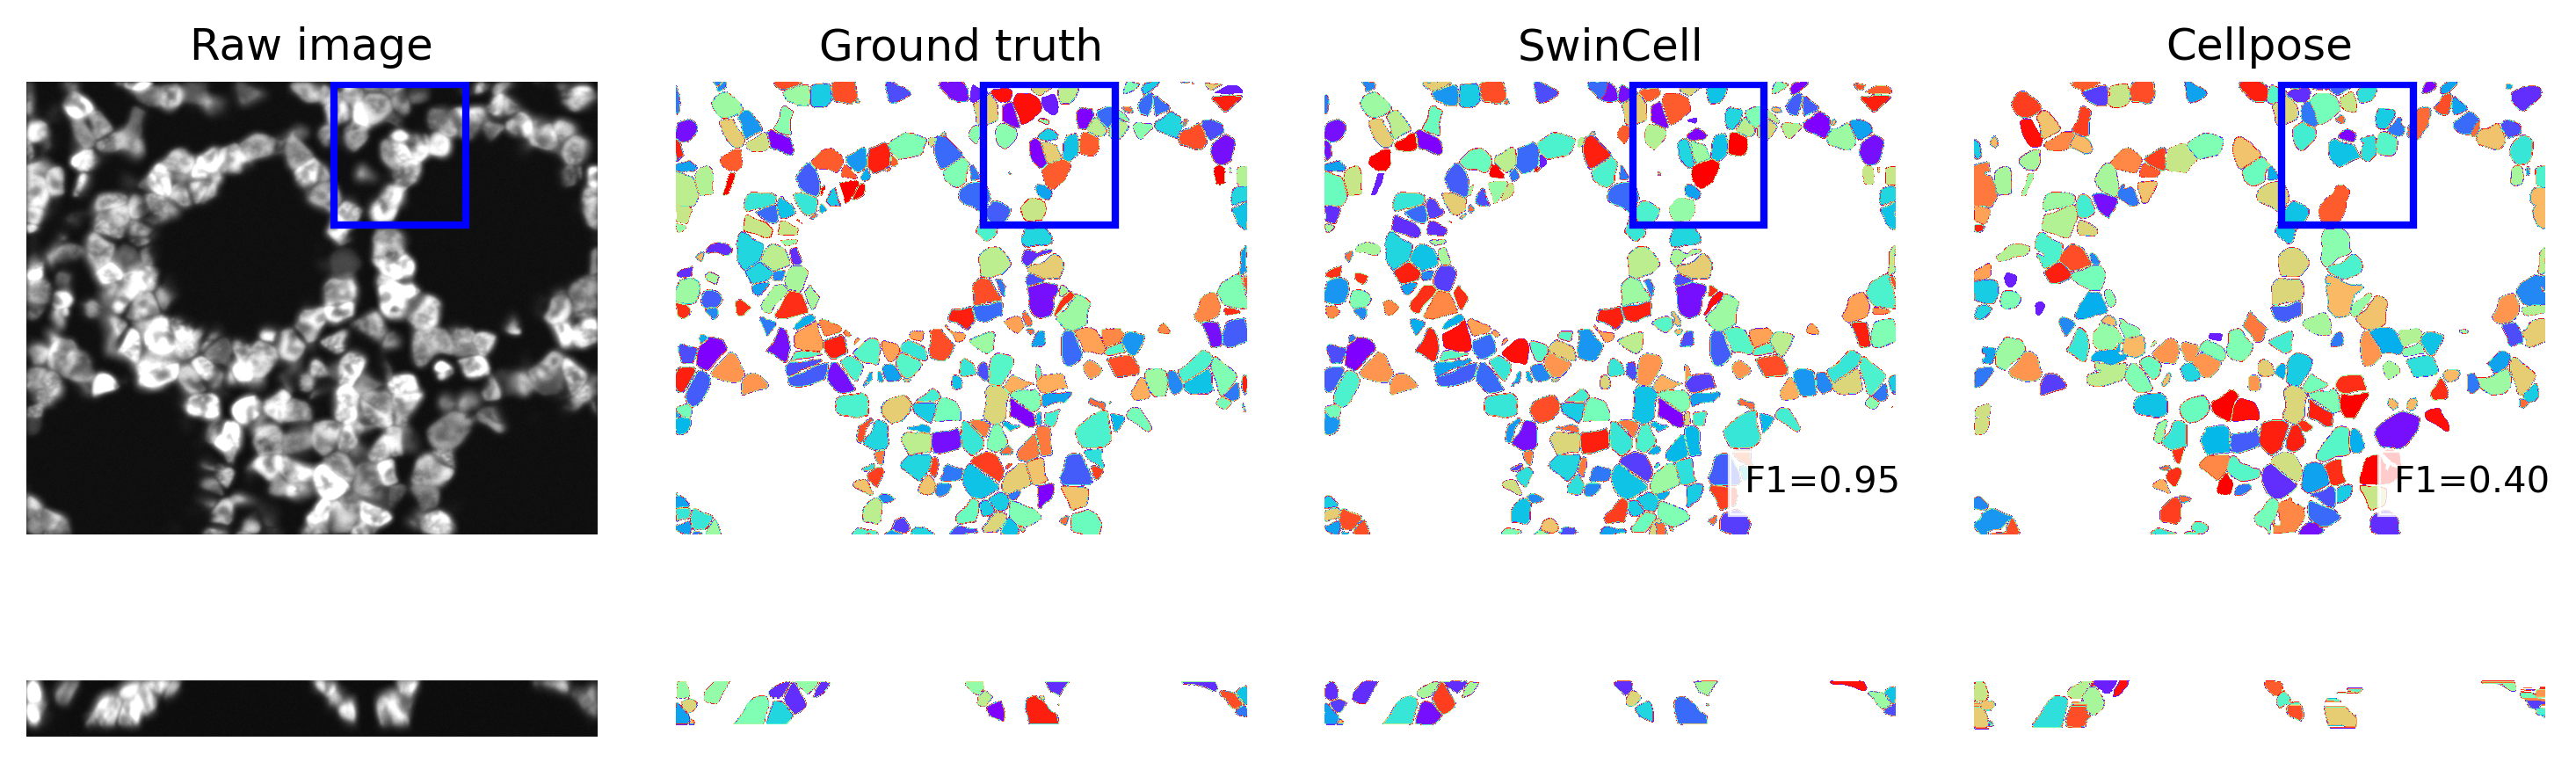

In [19]:


from skimage import measure
# mask =  measure.label(mask)






file_idx = 1
img_raw = tifffile.imread(image_files[file_idx])
img_gt = tifffile.imread(gt_files[file_idx])
img_gt = measure.label(img_gt,background=0)
img_seg_3d = tifffile.imread(seg_files_3d[file_idx])
img_seg_2d = tifffile.imread(seg_files_2d[file_idx])
# tifffile.imwrite('test_relabel_gt.tiff',np.uint16(img_gt))

textx = img_raw.shape[2]-345
texty = img_raw.shape[1]-95



print('gt min max',img_gt.max(),img_gt.min(),'seg min max',img_seg_3d.max(),img_seg_3d.min())
print(img_raw.shape)
slice1 = 50
slice2 = 450
fig,ax = plt.subplots(2,4,figsize=(10,4), dpi=300)
cell_num =50

colonf1_3d =matching(img_gt, img_seg_3d, thresh=0.5).f1
colonf1_2d =matching(img_gt, img_seg_2d, thresh=0.5).f1

ax[0,0].imshow(img_raw[slice1],cmap='gray')
ax[0,0].set_title('Raw image')

ax[0,1].imshow(img_gt[slice1],cmap= get_random_cmap(cell_num))
ax[0,1].set_title('Ground truth')

ax[0,2].imshow(img_seg_3d[slice1],cmap= get_random_cmap(cell_num))
ax[0,2].set_title('SwinCell')
ax[0,2].text(textx, texty, 'F1={:0.2f}'.format(colonf1_3d), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=10,)

ax[0,3].imshow(img_seg_2d[slice1],cmap= get_random_cmap(cell_num))
ax[0,3].set_title('Cellpose')
ax[0,3].text(textx, texty, 'F1={:0.2f}'.format(colonf1_2d), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=10,)

from matplotlib.patches import Rectangle
x1=10//2
x2=650//2
y1=700
y2=1000 
for i in range(4):
      blue_rect = Rectangle((y1, x1), y2-y1, x2-x1, linewidth=2, edgecolor='blue', facecolor='none')
      ax[0, i].add_patch(blue_rect)


if 0: # zoomin two times
      side_raw = ndimage.zoom(img_raw[:,slice2],(2,1),mode='nearest')
      side_gt = ndimage.zoom(img_gt[:,slice2],(2,1),mode='wrap',order=1)
      side_seg_3d  = ndimage.zoom(img_seg_3d[:,slice2],(2,1),mode='nearest')
      side_seg_2d  = ndimage.zoom(img_seg_2d[:,slice2],(2,1),mode='nearest')
else: # no zoom in
      side_raw = img_raw[:,slice2]
      side_gt = img_gt[:,slice2]
      side_seg_3d  = img_seg_3d[:,slice2]
      side_seg_2d  = img_seg_2d[:,slice2]
#-----
print(side_gt.max(),side_gt.min())
ax[1,0].imshow(side_raw,cmap='gray')
ax[1,1].imshow(side_gt,cmap= get_random_cmap(cell_num))
ax[1,2].imshow(side_seg_3d,cmap= get_random_cmap(cell_num))
ax[1,3].imshow(side_seg_2d,cmap= get_random_cmap(cell_num))
# slice3 =300
# side_raw2 = ndimage.zoom(img_raw[:,:,slice3],(2,1),mode='nearest')
# side_gt2 = ndimage.zoom(img_gt[:,:,slice3],(2,1),mode='nearest',order=1)
# side_seg2  = ndimage.zoom(img_seg[:,:,slice3],(2,1),mode='nearest')

# ax[2,0].imshow(side_raw2,cmap='gray')
# ax[2,1].imshow(side_gt2,cmap= get_random_cmap(cell_num))
# ax[2,2].imshow(side_seg2,cmap= get_random_cmap(cell_num))


for i in range(4):
      for j in range(2):
            ax[j,i].axis('off')
plt.tight_layout()


(129, 1030, 1300) (129, 1300)


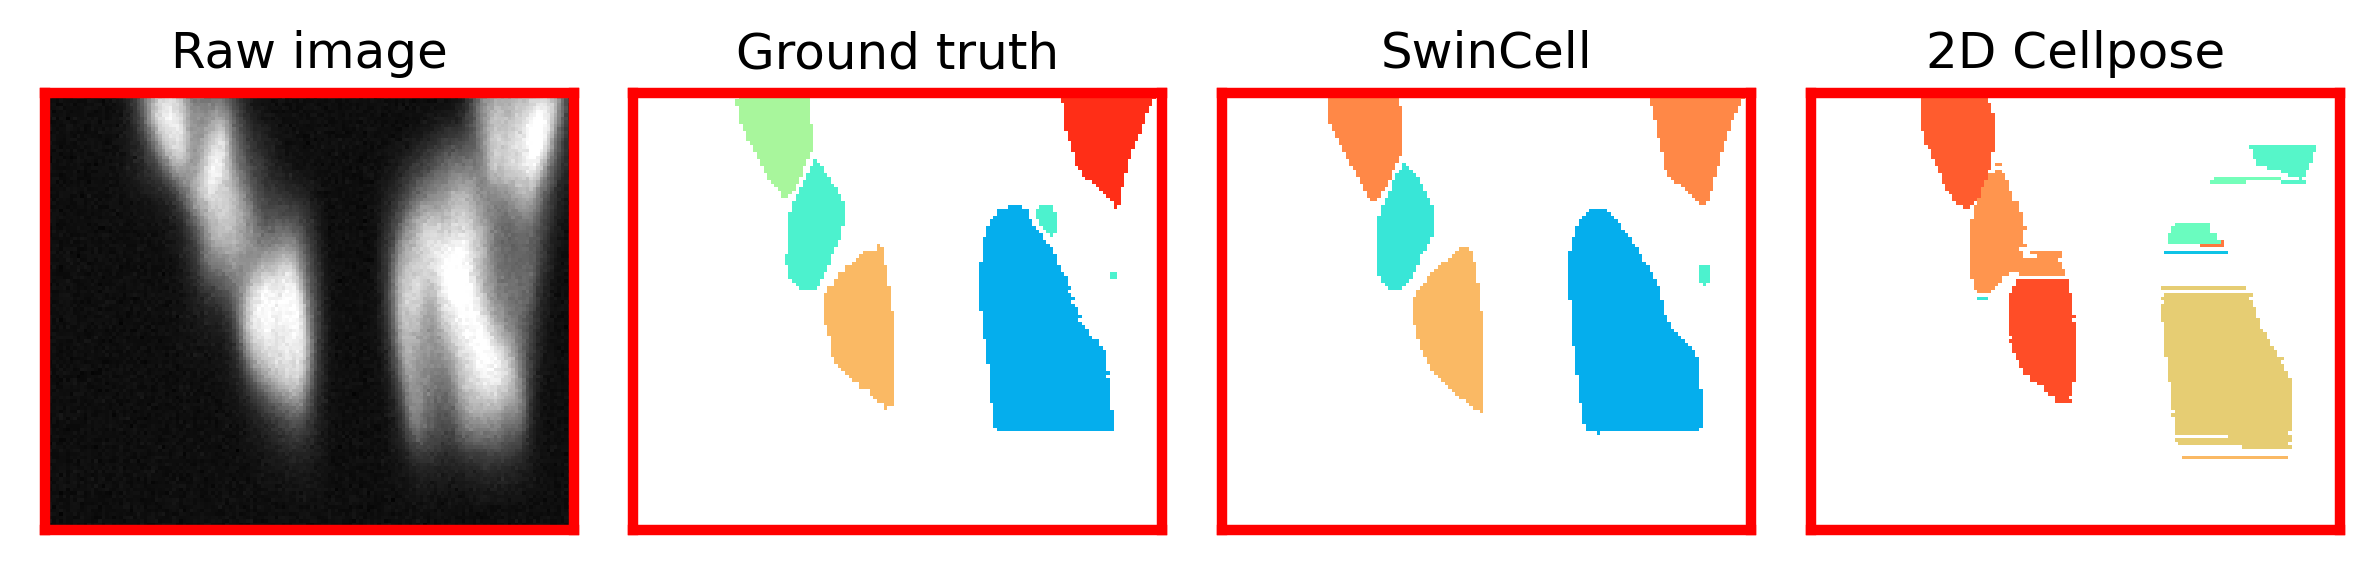

In [21]:
fig,axes = plt.subplots(1,4,figsize=(8,2), dpi=300)
print(img_raw.shape,side_raw.shape)

slice2 = 450

side_raw = img_raw[:,slice2]
side_gt =img_gt[:,slice2]
side_seg_3d  = img_seg_3d[:,slice2]
side_seg_2d  = img_seg_2d[:,slice2]
x1=10//2
x2=350//2
y1=600
y2=900

axes[0].imshow(side_raw[x1:x2,y1:y2:2],cmap='gray')
axes[0].set_title('Raw image')
axes[1].imshow(side_gt[x1:x2,y1:y2:2],cmap= get_random_cmap(cell_num,background=1))
axes[1].set_title('Ground truth')
axes[2].imshow(side_seg_3d[x1:x2,y1:y2:2],cmap= get_random_cmap(cell_num,background=1))
axes[2].set_title('SwinCell')
axes[3].imshow(side_seg_2d[x1:x2,y1:y2:2],cmap= get_random_cmap(cell_num,background=1))
axes[3].set_title('2D Cellpose')

# for ax in axes:
for i in range(4):
      ax = axes[i]
      ax.set_xticks([])
      ax.set_yticks([])

#     ax.tick_params(color='red', labelcolor='red')
      for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2.5)

plt.tight_layout()



(1030, 1300)


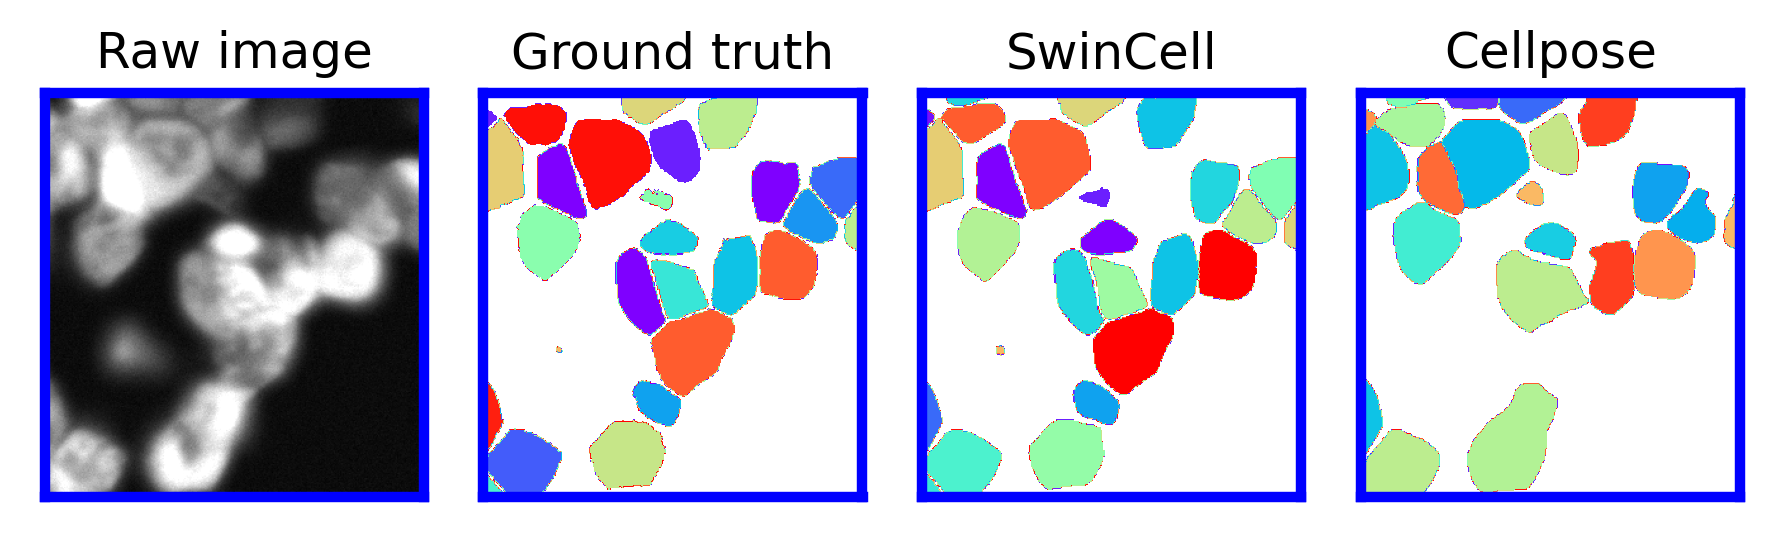

In [22]:
fig,axes = plt.subplots(1,4,figsize=(6,2), dpi=300)


ROI_raw = img_raw[slice1]
ROI_gt = img_gt[slice1]
ROI_seg_3d  = img_seg_3d[slice1]
ROI_seg_2d  = img_seg_2d[slice1]
print(ROI_raw.shape)
x1=10//2
x2=650//2
y1=700
y2=1000

axes[0].imshow(ROI_raw[x1:x2,y1:y2:1],cmap='gray')
axes[0].set_title('Raw image')
axes[1].imshow(ROI_gt[x1:x2,y1:y2:1],cmap= get_random_cmap(cell_num))
axes[1].set_title('Ground truth')
axes[2].imshow(ROI_seg_3d[x1:x2,y1:y2:1],cmap= get_random_cmap(cell_num))
axes[2].set_title('SwinCell')
axes[3].imshow(ROI_seg_2d[x1:x2,y1:y2:1],cmap= get_random_cmap(cell_num))
axes[3].set_title('Cellpose')

# for ax in axes:
for i in range(4):
      ax = axes[i]
      ax.set_xticks([])
      ax.set_yticks([])

#     ax.tick_params(color='red', labelcolor='red')
      for spine in ax.spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(2.5)

plt.tight_layout()

In [19]:
colon_match =matching(img_gt, img_seg, thresh=0.5)
print(colon_match)

Matching(criterion='iou', thresh=0.5, fp=122, tp=412, fn=73, precision=0.7715355805243446, recall=0.8494845360824742, accuracy=0.6787479406919276, f1=0.8086359175662414, n_true=485, n_pred=534, mean_true_score=0.6638176043009021, mean_matched_score=0.7814357720532463, panoptic_quality=0.6318970325533612)


In [23]:
from utils.utils import calculate_cell_volumes, plot_box_with_violin


def size_filter(mask):
    # Get unique labels excluding the background label (0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Calculate the volume of each cell
    volumes = []
    for label in labels:
        cell_volume = np.sum(mask == label)
        if cell_volume < 40:
            mask[mask==label] = 0

    return mask

import numpy as np
from scipy import ndimage



# Example usage:
# Assuming 'mask' is your 3D image mask as a numpy array
# cell_diameters = calculate_cell_diameters(mask)


# img_seg = size_filter(img_seg)

vol_gt = calculate_cell_volumes(img_gt)
vol_seg_3d = calculate_cell_volumes(img_seg_3d)
vol_seg_2d = calculate_cell_volumes(img_seg_2d)

# print(len(vol_gt))

# fig,ax = plt.subplots(1,2,figsize=(10,5), dpi=300)
# ax[0] = plot_box_with_violin(ax[0],[vol_gt,vol_seg],facecolorlist=['blue','red'])

In [24]:
from utils.utils import calculate_cell_diameters
from skimage import morphology
import numpy as np
import os
def postprocessing(img,threshold =0.5):

    img = np.uint8(img>threshold )[:,:,:]  # need 
    width = 10 
    #--------------2D processing-----------------------
    img1 = np.zeros_like(img,dtype = np.uint8)
    for i in range(img.shape[2]):
        img1[:,:,i] = morphology.remove_small_holes(img[:,:,i], width ** 2)
        img1[:,:,i] = morphology.remove_small_objects(img1[:,:,i], width ** 2)

    #-------------3D processing----------------------
    img2 = morphology.remove_small_holes(img1, width ** 3)
    img2 = morphology.remove_small_objects(img2, width ** 3)

    return img2

dia_gt = calculate_cell_diameters(img_gt)
dia_seg_3d = calculate_cell_diameters(img_seg_3d)
dia_seg_2d = calculate_cell_diameters(img_seg_2d)

In [13]:
# print(len(vol_gt),len(vol_seg))
# print(min(vol_seg), min(vol_gt))

print(len(vol_gt),len(vol_seg))
print(np.median(vol_gt),np.median(vol_seg))

485 465
68449.0 71690.0


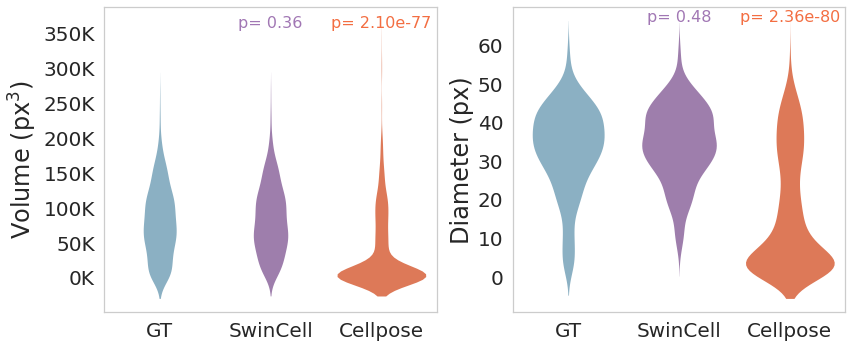

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu,ks_2samp

# Generate example volume data for two groups
# group_a_volumes = vol_gt
# group_b_volumes = vol_seg
# colors =[['#A5C8E1', '#FFDDC1'] ,['#2e8abf', '#D72638']]
# colors =[['#c0e1dd', '#dac3d8'],['#82b2cd', '#a177b4'] ]
factor= 1
factor2 = 1
# colors =[[(factor*0.75,factor*0.882,factor*0.867),(factor*0.855,factor*0.765,factor*0.847)],
#          [(factor*0.51,factor*0.7,factor*0.8),(factor*0.631,factor*0.466,factor*0.706)]
#          ]
colors =[[(factor*0.75,factor*0.882,factor*0.867),(factor*0.855,factor*0.765,factor*0.847),(factor2*0.95294118, factor2*0.43137255, factor2*0.25882353)],
         [(factor*0.51,factor*0.7,factor*0.8),(factor*0.631,factor*0.466,factor*0.706),(0.95294118, 0.43137255, 0.25882353)],
         ]
# colors

# Combine the volume data and create group labels
# all_volumes = np.concatenate([vol_gt, vol_seg])
all_volumes = np.concatenate([vol_gt, vol_seg_3d,vol_seg_2d])
all_diameters = np.concatenate([dia_gt, dia_seg_3d,dia_seg_2d])
volume_labels = ['GT'] * len(vol_gt) + ['SwinCell'] * len(vol_seg_3d) + ['Cellpose'] * len(vol_seg_2d)
diameter_labels = ['GT'] * len(dia_gt) + ['SwinCell'] * len(dia_seg_3d) + ['Cellpose'] * len(dia_seg_2d) 
# Perform Mann-Whitney U test
# statistic, p_value_vol = mannwhitneyu(vol_gt, vol_seg, alternative='two-sided')
# statistic, p_value_dia = mannwhitneyu(dia_gt, dia_seg, alternative='two-sided')
# Perform KS test
statistic, p_value_vol_3d = ks_2samp(vol_gt, vol_seg_3d)
statistic, p_value_dia_3d = ks_2samp(dia_gt, dia_seg_3d)

statistic, p_value_vol_2d = ks_2samp(vol_gt, vol_seg_2d)
statistic, p_value_dia_2d = ks_2samp(dia_gt, dia_seg_2d)

# Set up Seaborn style
sns.set(style='whitegrid')

# Create a figure with a violin plot using Seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

sns.violinplot(x=volume_labels, y=all_volumes, inner=None, palette=colors[1],linewidth=0)
# sns.swarmplot(x=volume_labels, y=all_volumes, palette=colors[1], size=3)

# Annotate the plot with the p-value in scientific notation
# plt.text(1, 1.05*np.max(all_volumes), f'p= {p_value_vol_3d:.2e}', horizontalalignment='center', fontsize=16, color='black')
plt.text(1, 1.05*np.max(all_volumes), f'p= {p_value_vol_3d:.2f}', horizontalalignment='center', fontsize=16, color=colors[1][1])
plt.text(2, 1.05*np.max(all_volumes), f'p= {p_value_vol_2d:.2e}', horizontalalignment='center', fontsize=16, color=colors[1][2])
# Set plot title and labels
# plt.title('Comparison of Volume Distributions', fontsize=24)
# plt.xlabel('Groups', fontsize=18)
# plt.ylabel('Volume (px)', fontsize=24)

from matplotlib.ticker import FuncFormatter
ax1 = plt.gca()
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000):,}K'))

plt.ylabel('Volume (px$^3$)', fontsize=24)


# Set tick label font size
plt.grid(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(1, 2, 2)
sns.violinplot(x=diameter_labels, y=all_diameters, inner=None, palette=colors[1],linewidth=0)
# sns.swarmplot(x=diameter_labels, y=all_diameters, palette=colors[1], size=3)

# plt.text(1, 1.1*np.max(all_diameters), f'p= {p_value_dia_3d:.2e}', horizontalalignment='center', fontsize=16, color='black')
plt.text(1, 1.1*np.max(all_diameters), f'p= {p_value_dia_3d:.2f}', horizontalalignment='center', fontsize=16, color=colors[1][1])
plt.text(2, 1.1*np.max(all_diameters), f'p= {p_value_dia_2d:.2e}', horizontalalignment='center', fontsize=16, color=colors[1][2])
# # Set plot title and labels
# # plt.title('Comparison of Volume Distributions', fontsize=24)
# plt.xlabel('Groups', fontsize=18)
plt.ylabel('Diameter (px)', fontsize=24)

# # Set tick label font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Adjust layout and save the plot
plt.tight_layout()
plt.grid(False)
# Show the plot or save it as an image
plt.show()


gt: 76410.0 459
pred: 79783.0 439


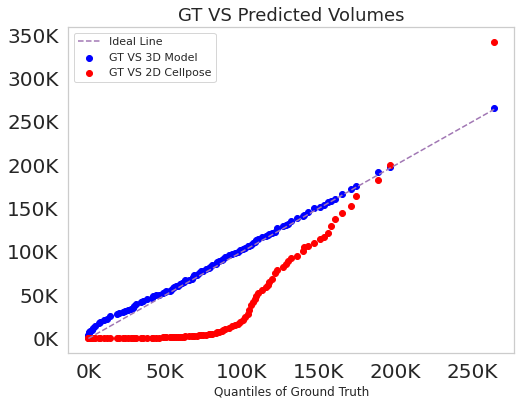

The two distributions are statistically the same (fail to reject null hypothesis).


In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data (replace with your actual data)
colors =[['#A5C8E1', '#FFDDC1'] ,['#2e8abf', '#D72638']]
colors =[['#c0e1dd', '#dac3d8'],['#82b2cd', '#a177b4'] ]

ground_truth = vol_gt
predicted_volumes_3d = vol_seg_3d
predicted_volumes_2d = vol_seg_2d
print('gt:',np.median(vol_gt),len(vol_gt))
print('pred:',np.median(vol_seg_3d),len(vol_seg_3d))
# Sort both datasets in ascending order
ground_truth.sort()
predicted_volumes_3d.sort()
predicted_volumes_2d.sort()

# Calculate the quantiles for both datasets
quantiles_ground_truth = np.percentile(ground_truth, np.arange(0, 101, 1))
quantiles_predicted_3d = np.percentile(predicted_volumes_3d, np.arange(0, 101, 1))
quantiles_predicted_2d = np.percentile(predicted_volumes_2d, np.arange(0, 101, 1))

# Create the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(quantiles_ground_truth, quantiles_predicted_3d, c='blue', marker='o', label='GT VS 3D Model')
plt.scatter(quantiles_ground_truth, quantiles_predicted_2d, c='red', marker='o', label='GT VS 2D Cellpose')

# Perform KS test
ks_statistic, ks_p_value = stats.ks_2samp(ground_truth, predicted_volumes_3d)

# Include KS test result in the plot
# plt.text(0.1, 0.65, f'KS Statistic: {ks_statistic:.4f}', transform=plt.gca().transAxes)
# plt.text(0.1, 0.60, f'p-value: {ks_p_value:.4f}', transform=plt.gca().transAxes)

plt.plot([0, max(quantiles_ground_truth)], [0, max(quantiles_ground_truth)], linestyle='--', color=colors[1][1], label='Ideal Line')
plt.xlabel('Quantiles of Ground Truth')
# plt.ylabel('Quantiles of Predicted Volumes')
plt.title('GT VS Predicted Volumes',fontsize=18)
#------------------------------------------------
from matplotlib.ticker import FuncFormatter
ax1 = plt.gca()
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000):,}K'))
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000):,}K'))

plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

# Perform hypothesis test based on p-value
alpha = 0.05  # Set your significance level
if ks_p_value > alpha:
    print("The two distributions are statistically the same (fail to reject null hypothesis).")
else:
    print("The two distributions are statistically different (reject null hypothesis).")

In [17]:
print('gt:',np.median(vol_gt),len(vol_gt))
print('pred:',np.median(vol_seg),len(vol_seg))




gt: 68449.0 485
pred: 47252.5 534
